In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from hydra import initialize, compose

In [2]:
initialize('../src/conf/')
cfg = compose(config_name='train.yaml')

In [11]:
def dataframe_preproc( df, columns=[] ):
    df.Prognosis.replace('SEVERE', 1, inplace=True)
    df.Prognosis.replace('MILD', 0, inplace=True)
    return df

def load_cv_data( cv=1, dataset='population_average', columns=[], include_death_column=False ):
    train_cv_df = pd.read_csv( cfg.datasets[dataset].cv_train_table+'cv'+str(cv)+'.csv')
    valid_cv_df = pd.read_csv( cfg.datasets[dataset].cv_valid_table+'cv'+str(cv)+'.csv')
    test_df = pd.read_csv(cfg.datasets[dataset].test_table)
    
    whole_test_df = pd.read_excel('/mnt/ncshare/ai4covid_hackathon/raw_data/completeTestClinData.xls')
    test_raw_df = whole_test_df[ ['ImageFile', 'Prognosis'] ]
    test_raw_df.Prognosis.replace('SEVERE', 1, inplace=True)
    test_raw_df.Prognosis.replace('MILD', 0, inplace=True)
    
    test_df.Prognosis = test_raw_df.Prognosis

    x_train = dataframe_preproc( train_cv_df, columns )
    x_valid = dataframe_preproc( valid_cv_df, columns )
    x_test = dataframe_preproc(test_df, columns)

    feature_names = x_train.columns
    
    return x_train, x_valid, x_test, feature_names

/opt/miniconda/envs/ai4covid/lib/python3.6/site-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Index(['PositivityAtAdmission', 'Temp_C', 'DaysFever', 'Cough',
       'DifficultyInBreathing', 'WBC', 'RBC', 'CRP', 'Fibrinogen', 'Glucose',
       'PCT', 'LDH', 'INR', 'D_dimer', 'Ox_percentage', 'PaO2', 'SaO2',
       'PaCO2', 'pH', 'CardiovascularDisease', 'IschemicHeartDisease',
       'AtrialFibrillation', 'HeartFailure', 'Ictus', 'HighBloodPressure',
       'Diabetes', 'Dementia', 'BPCO', 'Cancer', 'ChronicKidneyDisease',
       'RespiratoryFailure', 'Obesity'],
      dtype='object')


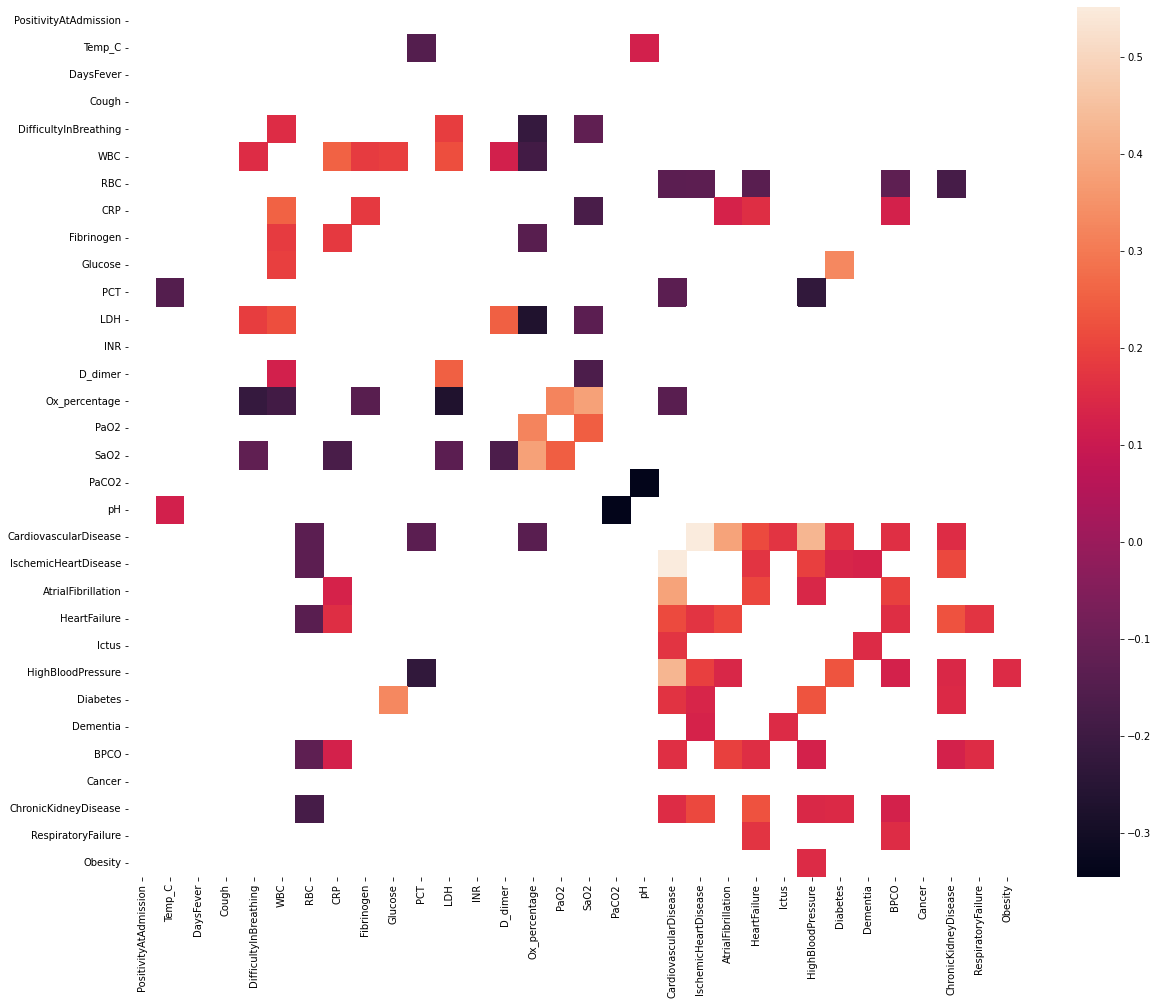

In [14]:
corr = np.zeros(shape=(32, 32))

for fold in range(1, 6):
    x_train, x_valid, x_test, feature_names = load_cv_data(cv=fold)
    x_train.drop(columns=['ImageFile', 'Prognosis', 'Death', 'Age', 'Sex', 'Position'], inplace=True)
    x_train.drop(columns=[f'Hospital_{letter}' for letter in ['A', 'B', 'C', 'D', 'E', 'F']],
                 inplace=True)
    _corr = x_train.corr()
    _corr -= np.eye(len(corr))
    corr += _corr

print(x_train.columns)

corr /= 5.

corrected_correlation = corr[np.abs(corr) > .12]

fig = plt.figure(figsize=(20, 16))    
sns.heatmap(corrected_correlation,
            xticklabels=x_train.columns,
            yticklabels=x_train.columns)
plt.show()    

In [15]:
cols_to_drop = set()
cols = set(list(range(corrected_correlation.shape[0])))

def update_set(index, corrected_correlation, cols_to_drop, cols):
    if index in cols:
        row_corr = corrected_correlation.values[index, :]
        indicies = np.argwhere(np.abs(row_corr) > 0).flatten().tolist()
        if len(indicies) > 0:
            return update_set(index + 1,
                              corrected_correlation,
                              cols_to_drop.union(set(indicies)),
                              cols.difference(set(indicies)))
        else:
            return update_set(index + 1,
                          corrected_correlation,
                          cols_to_drop,
                          cols) 
    elif index < corrected_correlation.shape[0]:
        return update_set(index + 1,
                          corrected_correlation,
                          cols_to_drop,
                          cols)
    else:
        return cols_to_drop
        

cols_to_be_dropped = update_set(0, corrected_correlation, cols_to_drop, cols)
cols_to_be_dropped

{5, 8, 10, 11, 14, 16, 18, 19, 20, 21, 22, 25, 26, 27, 29, 31}

In [16]:
x_train.columns[list(cols_to_be_dropped)]

Index(['WBC', 'Fibrinogen', 'PCT', 'LDH', 'Ox_percentage', 'SaO2', 'pH',
       'CardiovascularDisease', 'IschemicHeartDisease', 'AtrialFibrillation',
       'HeartFailure', 'Diabetes', 'Dementia', 'BPCO', 'ChronicKidneyDisease',
       'Obesity'],
      dtype='object')

/opt/miniconda/envs/ai4covid/lib/python3.6/site-packages/seaborn/matrix.py:198: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/opt/miniconda/envs/ai4covid/lib/python3.6/site-packages/seaborn/matrix.py:203: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


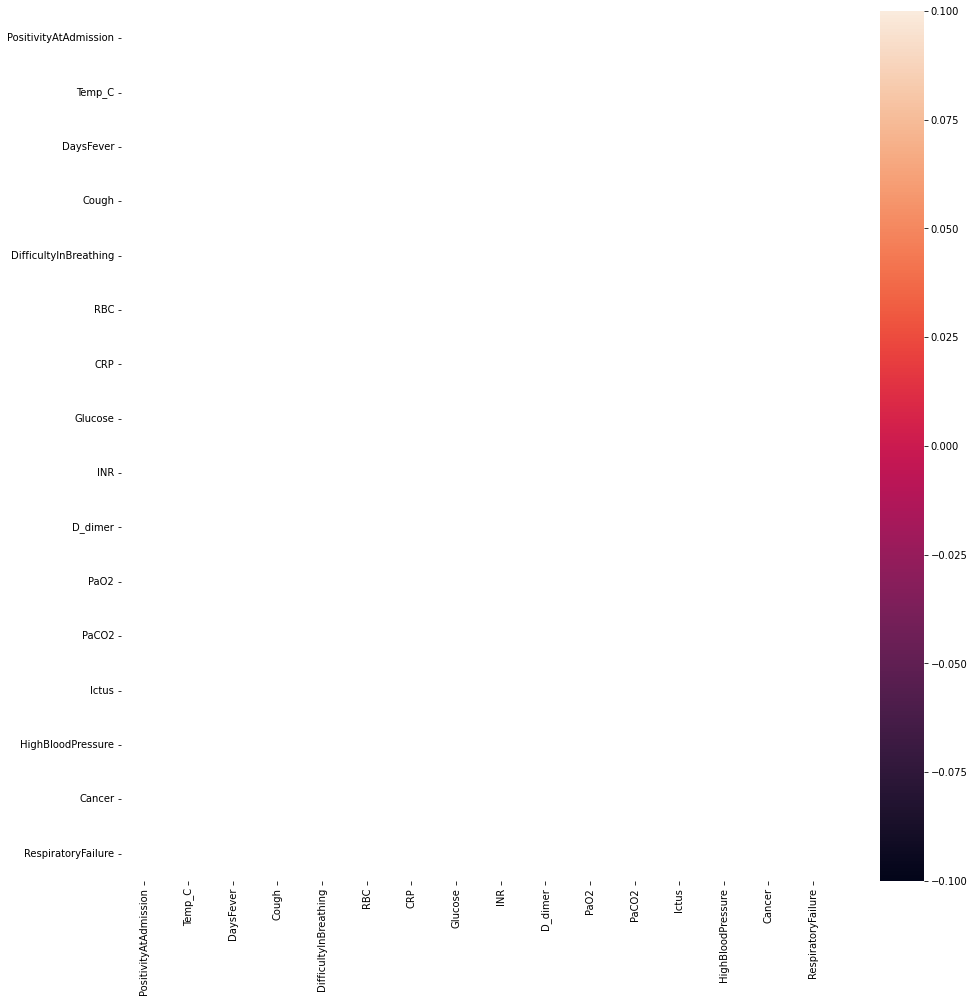

In [18]:
corr = np.zeros(shape=(16, 16))

for fold in range(1, 6):
    x_train, x_valid, x_test, feature_names = load_cv_data(cv=fold)
    x_train.drop(columns=['ImageFile', 'Prognosis', 'Death', 'Age', 'Sex', 'Position'], inplace=True)
    x_train.drop(columns=[f'Hospital_{letter}' for letter in ['A', 'B', 'C', 'D', 'E', 'F']],
                 inplace=True)
    x_train.drop(columns=x_train.columns[list(cols_to_be_dropped)], inplace=True)
    _corr = x_train.corr()
    _corr -= np.eye(len(corr))
    corr += _corr

corr /= 5.

fig = plt.figure(figsize=(16, 16))    
sns.heatmap(corr[np.abs(corr) > .2],
            xticklabels=x_train.columns,
            yticklabels=x_train.columns)
plt.show()    